In [1]:
"""
Sources:

2. https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a

"""

'\nSources:\n\n2. https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a\n\n'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
df = pd.read_csv("NVDA.csv")

In [27]:
from dateutil import relativedelta


In [2]:
# Define a function that extracts the year and month from a date and returns a new date with the first day of the month
def first_day_of_month(date):
    year = date.year
    month = date.month
    return pd.datetime(year, month, 1)

In [3]:
df.columns = [signal.lower().replace(" ", "_") for signal in df.columns] # upper to lower and replace space with underscores
#df.columns = [signal. for signal in df.columns]
df['date'] = pd.to_datetime(df['date']) # To date-time object conversion

# # Sample Here
df = df.resample('M', on='date').mean()
df.index = df.index.map(first_day_of_month)
# #df = df.set_index('date')
df = df[["close"]]

# idx = pd.date_range(df.index.min(),df.index.max(),freq='M')#.to_period('m')
# df.reindex(idx)

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [4]:
df

,close
date,
2000-01-01,0.886068
2000-02-01,1.101628
2000-03-01,1.870429
2000-04-01,1.746214
2000-05-01,2.005001
...,...
2022-07-01,163.304001
2022-08-01,177.622608
2022-09-01,131.744284


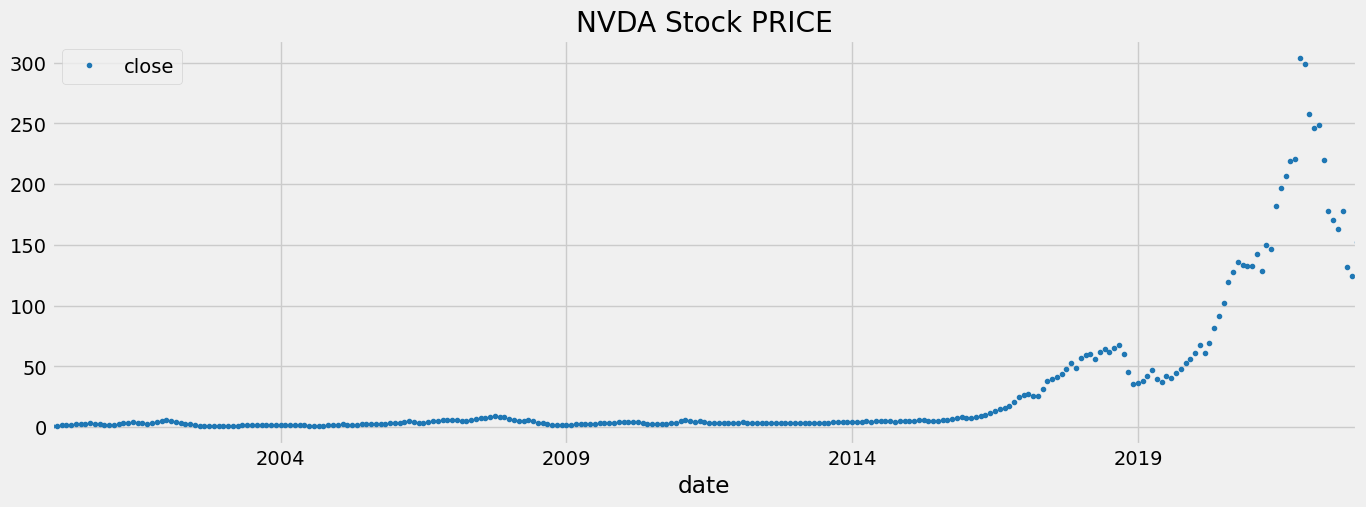

In [5]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='NVDA Stock PRICE')
plt.show()

## Outlier Checks

<AxesSubplot:ylabel='Frequency'>

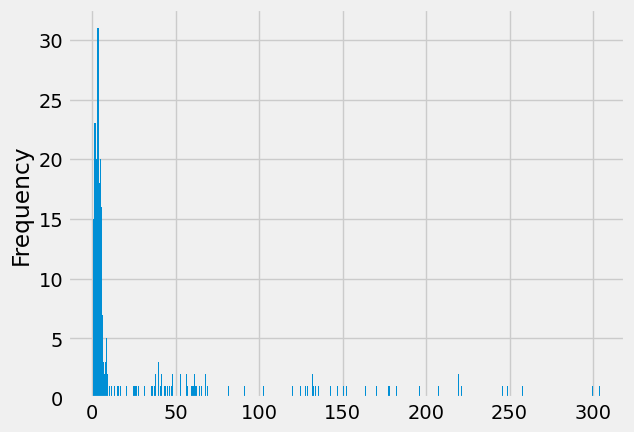

In [7]:
df['close'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='date'>

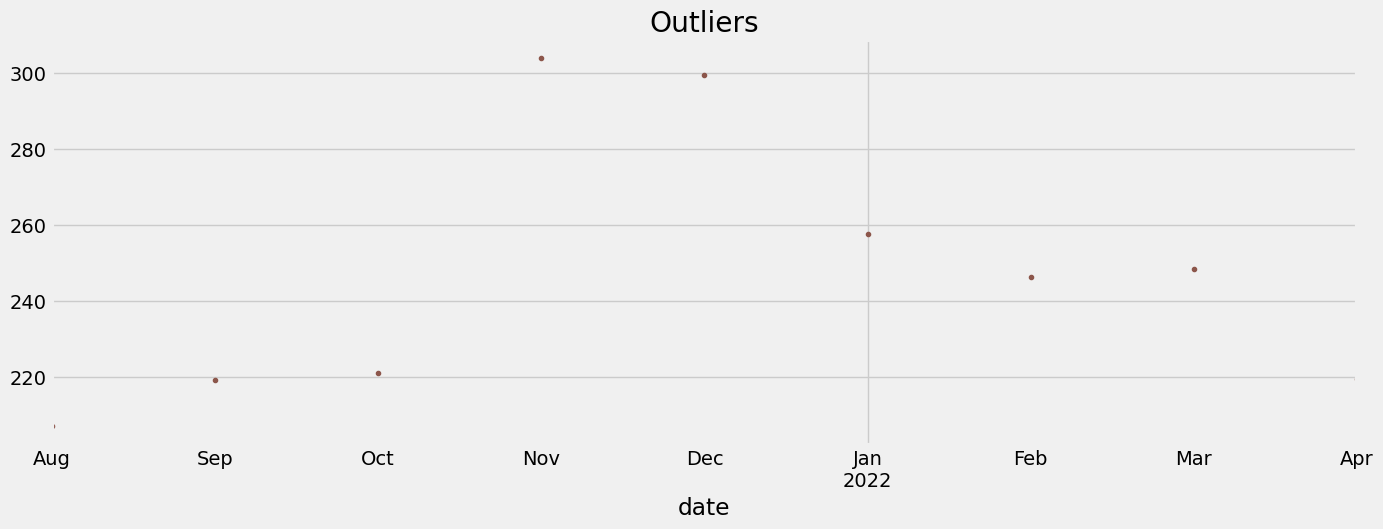

In [8]:
df.query('close > 200')['close'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

## Train/Test Split

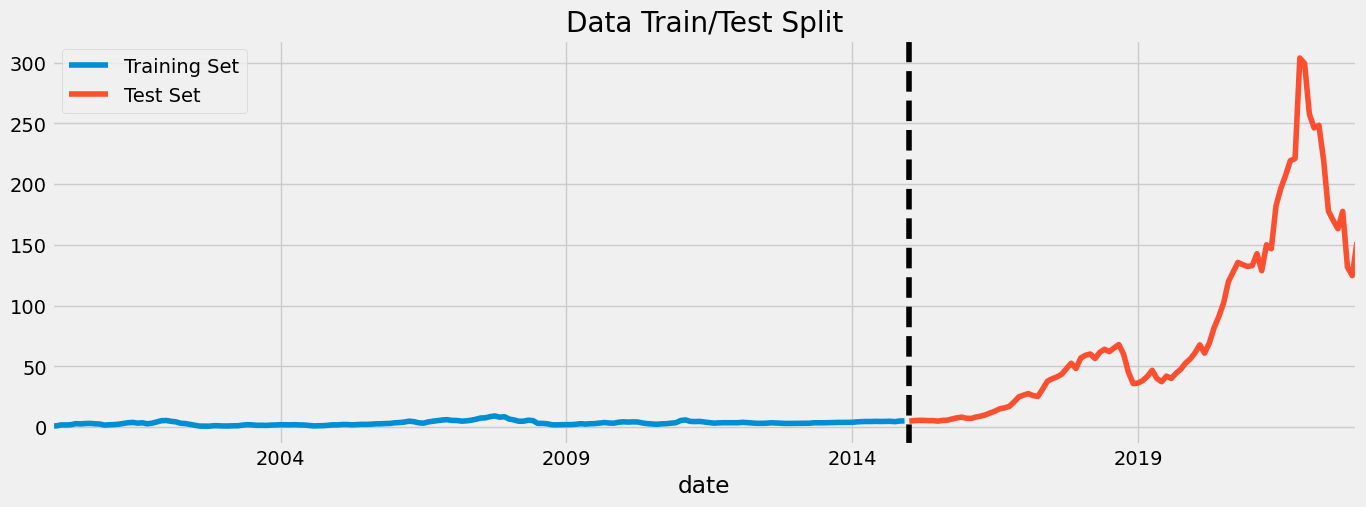

In [9]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Train/Test Cross Validation

In [10]:
from sklearn.model_selection import TimeSeriesSplit

# Split data n times and from those n datasets, set aside m number of test data points
tss = TimeSeriesSplit(n_splits=6, test_size=12*2, gap=0) # How much should gap be? 365 * 2
df = df.sort_index()

In [11]:
tss

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=24)

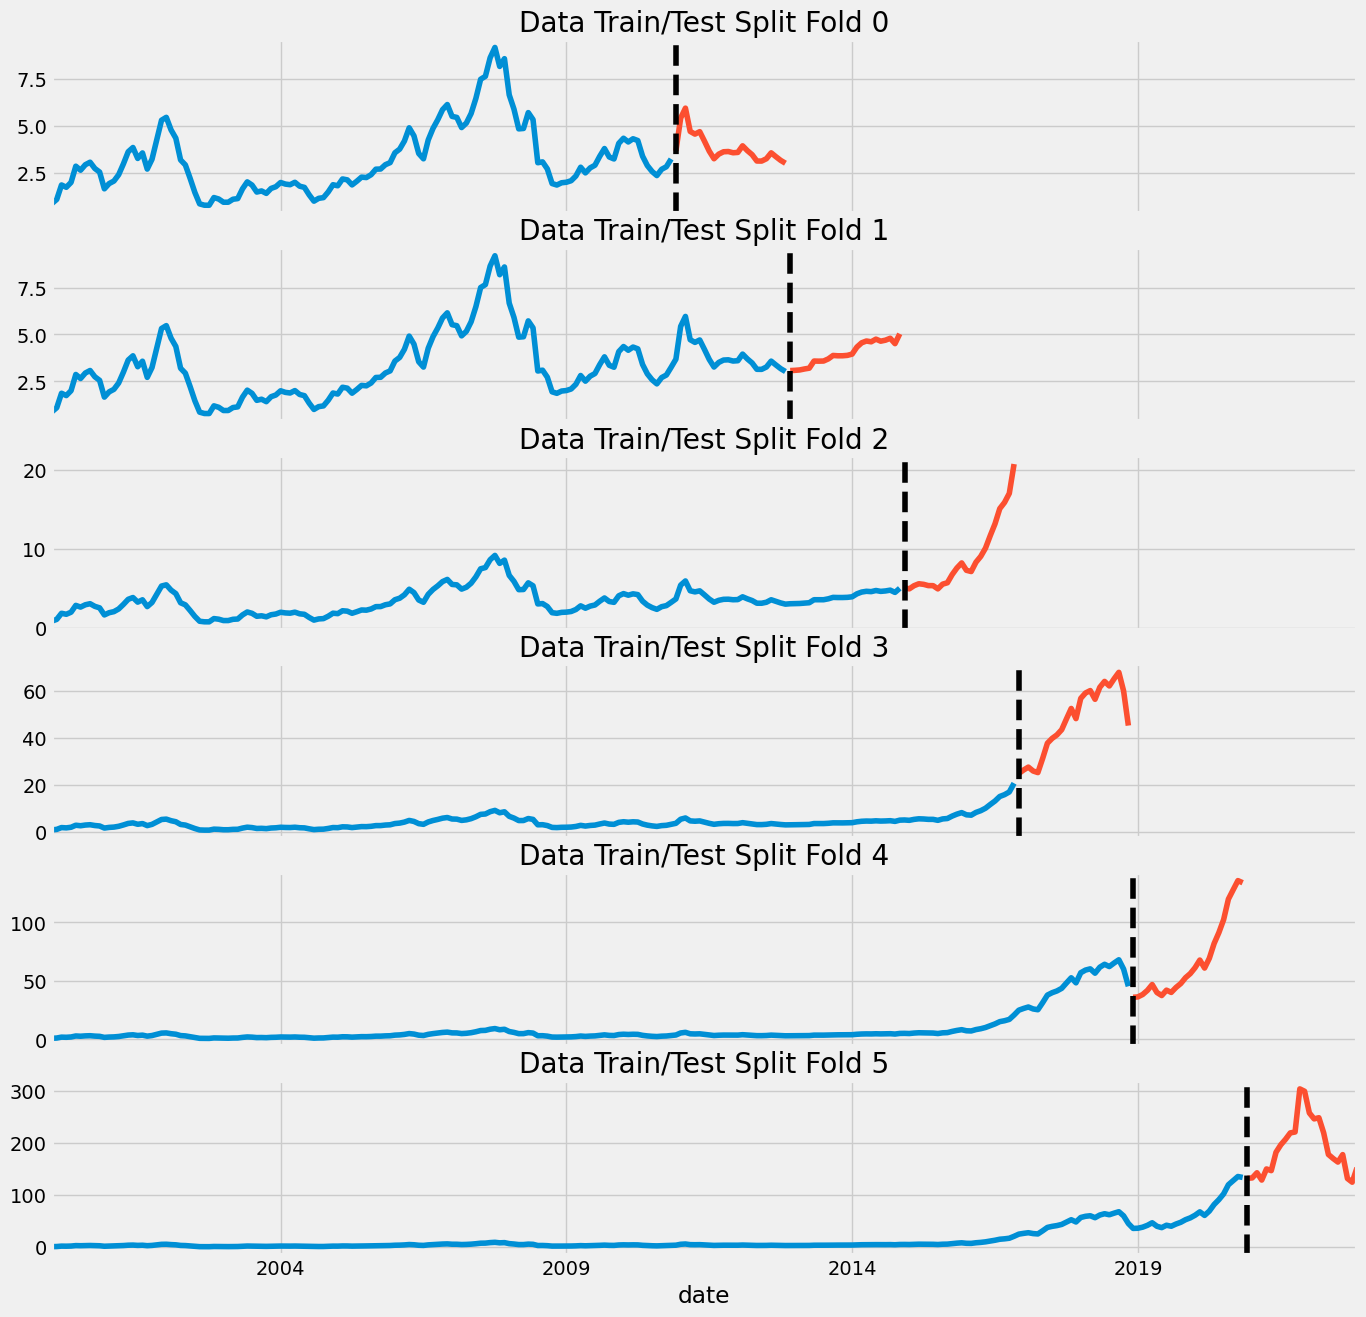

In [12]:
fig, axs = plt.subplots(6, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    #print(val_idx)
    train = df.iloc[train_idx] # count of 12*2
    test = df.iloc[val_idx]
    train['close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    #df['dayofyear'] = df.index.dayofyear
    #df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    return df

feature_df = create_features(df)

In [7]:
feature_df = feature_df[["close", "quarter", "month", "year"]]
feature_df

,close,quarter,month,year
date,,,,
2000-01-01,0.886068,1,1,2000
2000-02-01,1.101628,1,2,2000
2000-03-01,1.870429,1,3,2000
2000-04-01,1.746214,2,4,2000
2000-05-01,2.005001,2,5,2000
...,...,...,...,...
2022-07-01,163.304001,3,7,2022
2022-08-01,177.622608,3,8,2022
2022-09-01,131.744284,3,9,2022


In [8]:
def add_lags(df, num_lags):
    df = df.copy()
    lag_lst = []
    target_map = df['close'].to_dict() # date: close_val pair (key, val)
    # df = df[~df['dayofweek'].isin([5, 6])] # Exclude weekends. Enable this when doing daily forecasts

    for lag in range(1, num_lags):
        df[f'lag{lag}'] = (df.index - pd.DateOffset(months=lag)).map(target_map)
        #df[f'lag{lag}'] = (df.index - pd.Timedelta(f'{lag} days')).map(target_map)
        lag_lst.append(f'lag{lag}')
        
    # df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364
    # df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map) # 728
    # df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map) # 1092
    return df, lag_lst

In [9]:
lagged_df, lag_lst = add_lags(feature_df, 25)

In [10]:
lagged_df

,close,quarter,month,year,lag1,lag2,lag3,lag4,lag5,lag6,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.886068,1,1,2000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,1.101628,1,2,2000,0.886068,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,1.870429,1,3,2000,1.101628,0.886068,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,1.746214,2,4,2000,1.870429,1.101628,0.886068,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,2.005001,2,5,2000,1.746214,1.870429,1.101628,0.886068,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,163.304001,3,7,2022,170.159047,177.905714,219.607001,248.516521,246.289473,257.702501,...,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500,127.729525,119.750714,102.265341
2022-08-01,177.622608,3,8,2022,163.304001,170.159047,177.905714,219.607001,248.516521,246.289473,...,146.881999,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500,127.729525,119.750714
2022-09-01,131.744284,3,9,2022,177.622608,163.304001,170.159047,177.905714,219.607001,248.516521,...,182.186704,146.881999,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500,127.729525


In [18]:
"""
TODO: Refactor....

"""
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots() # Init subplot

    palette = sns.color_palette("husl", n_colors=X[period].nunique()) # Array of rgb colors
    ax = sns.lineplot(x=freq, y=y, hue=period, data=X, ci=False, ax=ax, palette=palette, legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")

    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1] # Get last y data
        ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(), xycoords=ax.get_yaxis_transform(), textcoords="offset points", size=14, va="center")
    return ax


KeyError: 'year'

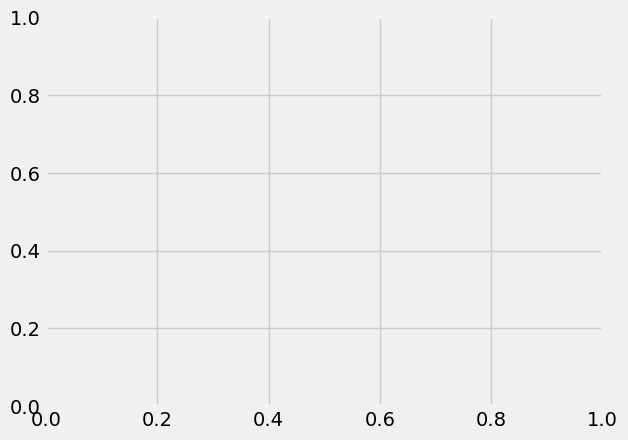

In [19]:
seasonal_plot(df, y='close', period='year', freq='month');


In [19]:
lagged_df

,close,quarter,month,year,lag1,lag2,lag3,lag4,lag5,lag6,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.886068,1,1,2000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,1.101628,1,2,2000,0.886068,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,1.870429,1,3,2000,1.101628,0.886068,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,1.746214,2,4,2000,1.870429,1.101628,0.886068,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,2.005001,2,5,2000,1.746214,1.870429,1.101628,0.886068,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,163.304001,3,7,2022,170.159047,177.905714,219.607001,248.516521,246.289473,257.702501,...,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500,127.729525,119.750714,102.265341
2022-08-01,177.622608,3,8,2022,163.304001,170.159047,177.905714,219.607001,248.516521,246.289473,...,146.881999,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500,127.729525,119.750714
2022-09-01,131.744284,3,9,2022,177.622608,163.304001,170.159047,177.905714,219.607001,248.516521,...,182.186704,146.881999,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500,127.729525


In [11]:
FEATURES = []
for i in range(1,25):
    FEATURES.append(f"lag{i}")

In [12]:
FEATURES

['lag1',
 'lag2',
 'lag3',
 'lag4',
 'lag5',
 'lag6',
 'lag7',
 'lag8',
 'lag9',
 'lag10',
 'lag11',
 'lag12',
 'lag13',
 'lag14',
 'lag15',
 'lag16',
 'lag17',
 'lag18',
 'lag19',
 'lag20',
 'lag21',
 'lag22',
 'lag23',
 'lag24']

In [22]:
tss = TimeSeriesSplit(n_splits=5, test_size=12*2, gap=0)
lagged_df = lagged_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(lagged_df):
    train = lagged_df.iloc[train_idx]
    test = lagged_df.iloc[val_idx]

    # We have already created the features
    # train = create_features(train)
    # test = create_features(test)

    #FEATURES = ['lag1','lag2','lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag]
    TARGET = 'close'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[01:22:59] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.23300	validation_1-rmse:3.52868
[100]	validation_0-rmse:1.32299	validation_1-rmse:1.39701
[200]	validation_0-rmse:0.60828	validation_1-rmse:0.70034
[300]	validation_0-rmse:0.35291	validation_1-rmse:0.43503
[400]	validation_0-rmse:0.26208	validation_1-rmse:0.35915
[500]	validation_0-rmse:0.22556	validation_1-rmse:0.33524
[600]	validation_0-rmse:0.20161	validation_1-rmse:0.32778
[654]	validation_0-rmse:0.18690	validation_1-rmse:0.33453
[01:23:05] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.27357	validation_1-rmse:9.35947
[100]	validation_0-rmse:1.32247	validation_1-rmse:6.26620
[200]	validation_0-rmse:0.59896	validation_1-rmse:5.32348
[300]	validation_0-rmse:0.34138	validation_1-rmse:5.11516
[400]	validation_0-rmse:0.25711	validation_1-rmse:5.06880
[500]	valida

In [23]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 29.8801
Fold scores:[0.3274242948317134, 5.01537198776598, 30.579451784564878, 36.21762630969207, 77.26062711807556]


In [24]:
lagged_df

,close,quarter,month,year,lag1,lag2,lag3,lag4,lag5,lag6,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.886068,1,1,2000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,1.101628,1,2,2000,0.886068,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,1.870429,1,3,2000,1.101628,0.886068,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,1.746214,2,4,2000,1.870429,1.101628,0.886068,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,2.005001,2,5,2000,1.746214,1.870429,1.101628,0.886068,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,163.304001,3,7,2022,170.159047,177.905714,219.607001,248.516521,246.289473,257.702501,...,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500,127.729525,119.750714,102.265341
2022-08-01,177.622608,3,8,2022,163.304001,170.159047,177.905714,219.607001,248.516521,246.289473,...,146.881999,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500,127.729525,119.750714
2022-09-01,131.744284,3,9,2022,177.622608,163.304001,170.159047,177.905714,219.607001,248.516521,...,182.186704,146.881999,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500,127.729525


## Predicting the Future

In [13]:
# Retrain on all data
#df = create_features(df) # already done this

FEATURES = ['quarter', 'month', 'year']

FEATURES = FEATURES + lag_lst 
TARGET = 'close'

X_all = lagged_df[FEATURES]
y_all = lagged_df[TARGET]
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
# reg = xgb.XGBRegressor(base_score=0.5,
#                        booster='gbtree',    
#                        n_estimators=1000,
#                        objective='reg:linear',
#                        max_depth=3,
#                        learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[03:07:09] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:62.97591
[100]	validation_0-rmse:26.00431
[200]	validation_0-rmse:11.55890
[300]	validation_0-rmse:5.54237
[400]	validation_0-rmse:2.94109
[500]	validation_0-rmse:1.80049
[600]	validation_0-rmse:1.29325
[700]	validation_0-rmse:1.04401
[800]	validation_0-rmse:0.88351
[900]	validation_0-rmse:0.77464
[999]	validation_0-rmse:0.70037


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [17]:
df_copy = df.copy()

# Create future dataframe
future = pd.date_range('2022-12-1','2023-11-1', freq='1m')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
future_df.index = future_df.index.map(first_day_of_month)

df_copy['isFuture'] = False
df_and_future = pd.concat([df_copy, future_df])
df_and_future = create_features(df_and_future)
df_and_future, _ = add_lags(df_and_future, 25)

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [19]:
df_and_future

,close,isFuture,quarter,month,year,lag1,lag2,lag3,lag4,lag5,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
2000-01-01,0.886068,False,1,1,2000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,1.101628,False,1,2,2000,0.886068,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,1.870429,False,1,3,2000,1.101628,0.886068,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,1.746214,False,2,4,2000,1.870429,1.101628,0.886068,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,2.005001,False,2,5,2000,1.746214,1.870429,1.101628,0.886068,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,NaN,True,2,6,2023,NaN,NaN,NaN,NaN,NaN,...,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452,182.186704
2023-07-01,NaN,True,3,7,2023,NaN,NaN,NaN,NaN,NaN,...,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452
2023-08-01,NaN,True,3,8,2023,NaN,NaN,NaN,NaN,NaN,...,177.905714,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819
2023-09-01,NaN,True,3,9,2023,NaN,NaN,NaN,NaN,NaN,...,170.159047,177.905714,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716


In [22]:
future_w_features = df_and_future.query('isFuture').copy()

In [23]:
future_w_features[FEATURES]

,quarter,month,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
2022-12-01,4,12,2022,152.331001,124.698095,131.744284,177.622608,163.304001,170.159047,177.905714,...,219.365716,207.121819,196.463452,182.186704,146.881999,150.102975,128.761088,142.772764,132.878553,132.247387
2023-01-01,1,1,2023,NaN,152.331001,124.698095,131.744284,177.622608,163.304001,170.159047,...,221.104285,219.365716,207.121819,196.463452,182.186704,146.881999,150.102975,128.761088,142.772764,132.878553
2023-02-01,1,2,2023,NaN,NaN,152.331001,124.698095,131.744284,177.622608,163.304001,...,303.885238,221.104285,219.365716,207.121819,196.463452,182.186704,146.881999,150.102975,128.761088,142.772764
2023-03-01,1,3,2023,NaN,NaN,NaN,152.331001,124.698095,131.744284,177.622608,...,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452,182.186704,146.881999,150.102975,128.761088
2023-04-01,2,4,2023,NaN,NaN,NaN,NaN,152.331001,124.698095,131.744284,...,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452,182.186704,146.881999,150.102975
2023-05-01,2,5,2023,NaN,NaN,NaN,NaN,NaN,152.331001,124.698095,...,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452,182.186704,146.881999
2023-06-01,2,6,2023,NaN,NaN,NaN,NaN,NaN,NaN,152.331001,...,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452,182.186704
2023-07-01,3,7,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452
2023-08-01,3,8,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,177.905714,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819
2023-09-01,3,9,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,170.159047,177.905714,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716


In [24]:
df_and_future

,close,isFuture,quarter,month,year,lag1,lag2,lag3,lag4,lag5,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
2000-01-01,0.886068,False,1,1,2000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,1.101628,False,1,2,2000,0.886068,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,1.870429,False,1,3,2000,1.101628,0.886068,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,1.746214,False,2,4,2000,1.870429,1.101628,0.886068,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,2.005001,False,2,5,2000,1.746214,1.870429,1.101628,0.886068,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,NaN,True,2,6,2023,NaN,NaN,NaN,NaN,NaN,...,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452,182.186704
2023-07-01,NaN,True,3,7,2023,NaN,NaN,NaN,NaN,NaN,...,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452
2023-08-01,NaN,True,3,8,2023,NaN,NaN,NaN,NaN,NaN,...,177.905714,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819
2023-09-01,NaN,True,3,9,2023,NaN,NaN,NaN,NaN,NaN,...,170.159047,177.905714,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716


## Think i finally know what's going on

In [69]:
def forecastData(df, target, horizon, num_lags):
    """
    Produce forecasts on feature engineered data frame (e.g. lagged and categorical features...)
    
    :param df: featured engineered data frame
    """
    for forecast_step in reversed(range(0, horizon)):
        df.iloc[-1:]
        res = reg.predict(df.iloc[-1:][FEATURES]) # Predict using features | [Last Total Rows Generated, Specific Row from the end]
        future_date = df.index.max() + relativedelta.relativedelta(months=1)
        step_ahead_forecast = {'date': future_date, target: res, 'isFuture': True}
        step_ahead_df = pd.DataFrame(step_ahead_forecast) # Save forecast result in step ahead
        step_ahead_df.set_index("date", inplace= True)
        step_ahead_df = create_features(step_ahead_df)
        df = pd.concat([df, step_ahead_df])
        df, _ = add_lags(df, num_lags) # Add lags to next set of features
        
    return df



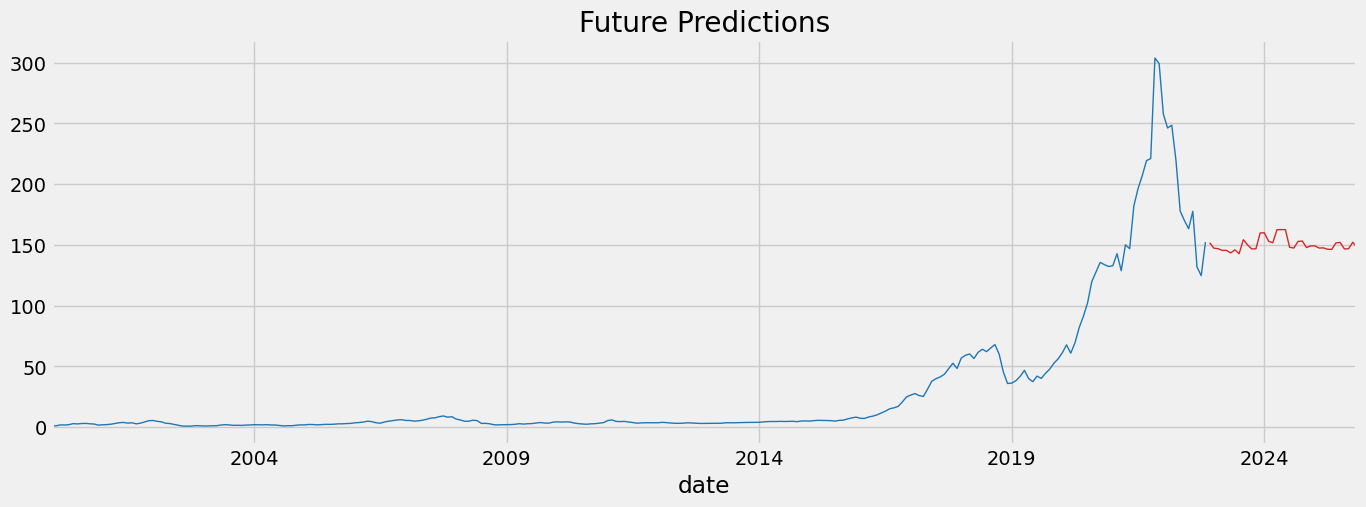

In [85]:
#from datetime import datetime

forecast_results = forecastData(df = lagged_df, target = "close", horizon = 36, num_lags = 25)

#Plot this
past_df = forecast_results.loc[forecast_results.index < '12-01-2022']
future_df = forecast_results.loc[forecast_results.index >= '12-01-2022']
future_df["close"].plot(figsize=(15, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
past_df["close"].plot(figsize=(15, 5),
                               color=color_pal[0],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [81]:
forecast_results.tail(40)

,close,quarter,month,year,lag1,lag2,lag3,lag4,lag5,lag6,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,isFuture
date,,,,,,,,,,,,,,,,,,,,,
2021-08-01,207.121819,3,8,2021,196.463452,182.186704,146.881999,150.102975,128.761088,142.772764,...,69.249167,60.888182,67.733159,61.203214,56.162976,52.656250,47.666739,44.315000,40.093863,NaN
2021-09-01,219.365716,3,9,2021,207.121819,196.463452,182.186704,146.881999,150.102975,128.761088,...,81.838125,69.249167,60.888182,67.733159,61.203214,56.162976,52.656250,47.666739,44.315000,NaN
2021-10-01,221.104285,4,10,2021,219.365716,207.121819,196.463452,182.186704,146.881999,150.102975,...,91.157501,81.838125,69.249167,60.888182,67.733159,61.203214,56.162976,52.656250,47.666739,NaN
2021-11-01,303.885238,4,11,2021,221.104285,219.365716,207.121819,196.463452,182.186704,146.881999,...,102.265341,91.157501,81.838125,69.249167,60.888182,67.733159,61.203214,56.162976,52.656250,NaN
2021-12-01,299.307272,4,12,2021,303.885238,221.104285,219.365716,207.121819,196.463452,182.186704,...,119.750714,102.265341,91.157501,81.838125,69.249167,60.888182,67.733159,61.203214,56.162976,NaN
2022-01-01,257.702501,1,1,2022,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452,...,127.729525,119.750714,102.265341,91.157501,81.838125,69.249167,60.888182,67.733159,61.203214,NaN
2022-02-01,246.289473,1,2,2022,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819,...,135.597500,127.729525,119.750714,102.265341,91.157501,81.838125,69.249167,60.888182,67.733159,NaN
2022-03-01,248.516521,1,3,2022,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,...,133.789250,135.597500,127.729525,119.750714,102.265341,91.157501,81.838125,69.249167,60.888182,NaN
2022-04-01,219.607001,2,4,2022,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,...,132.247387,133.789250,135.597500,127.729525,119.750714,102.265341,91.157501,81.838125,69.249167,NaN


<AxesSubplot:xlabel='date'>

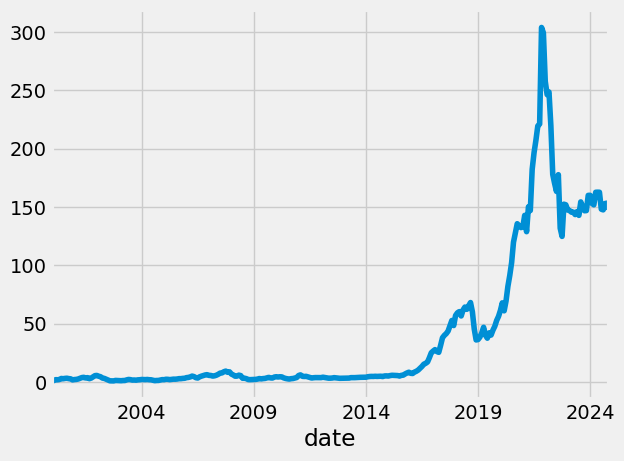

In [51]:
forecast_results['close'].plot()

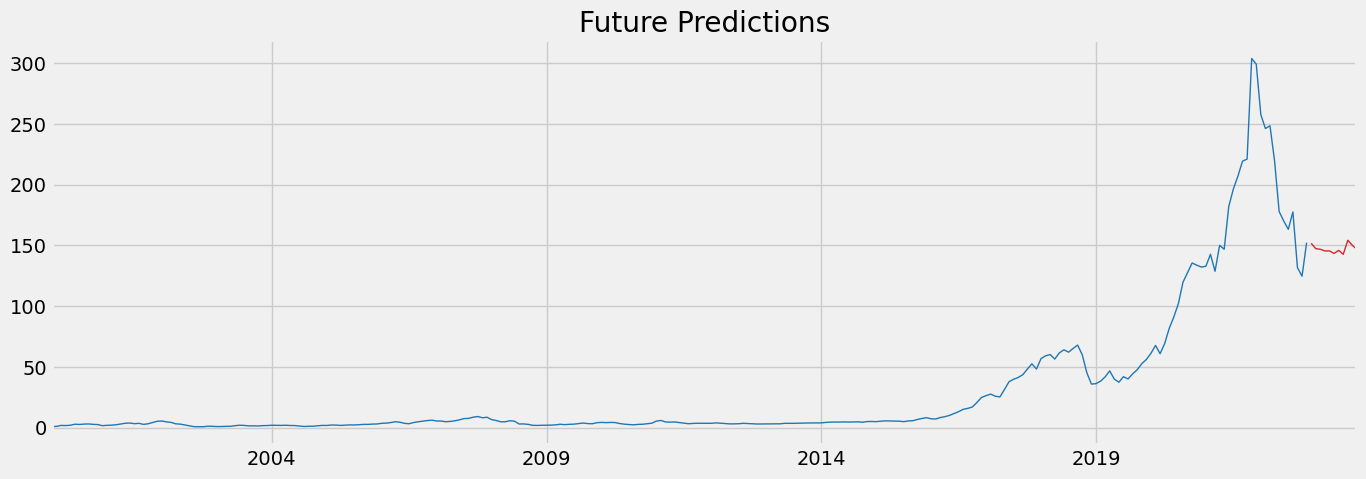

In [102]:
"""
Method using Existing Code
"""
lag_size = 25
len_data = len(df_and_future)

forecast_horizon = 11
for forecast_step in reversed(range(0,forecast_horizon)):
    begin_slice = len_data - (forecast_step + 1)
    end_slice = len_data - forecast_step
    res = reg.predict(df_and_future.iloc[begin_slice:end_slice][FEATURES]) # Predict using features | [Last Total Rows Generated, Specific Row from the end]
    df_and_future.loc[df_and_future.iloc[begin_slice+1:end_slice+1].index, 'close'] = res # Save forecast result in step ahead
    df_and_future, _ = add_lags(df_and_future, lag_size) # Add lags to next set of features
    

    
# Plot this
past_df = df_and_future.loc[df_and_future.index < '12-01-2022']
future_df = df_and_future.loc[df_and_future.index >= '12-01-2022']
future_df["close"].plot(figsize=(15, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
past_df["close"].plot(figsize=(15, 5),
                               color=color_pal[0],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [103]:
df_and_future

,close,isFuture,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
2000-01-01,0.886068,False,5,1,1,2000,1,1,52,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,1.101628,False,1,1,2,2000,32,1,5,0.886068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,1.870429,False,2,1,3,2000,61,1,9,1.101628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,1.746214,False,5,2,4,2000,92,1,13,1.870429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,2.005001,False,0,2,5,2000,122,1,18,1.746214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,145.971375,True,3,2,6,2023,152,1,22,143.440353,...,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452,182.186704
2023-07-01,142.745697,True,5,3,7,2023,182,1,26,145.971375,...,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819,196.463452
2023-08-01,154.292526,True,1,3,8,2023,213,1,31,142.745697,...,177.905714,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716,207.121819
2023-09-01,150.084320,True,4,3,9,2023,244,1,35,154.292526,...,170.159047,177.905714,219.607001,248.516521,246.289473,257.702501,299.307272,303.885238,221.104285,219.365716


## Predict Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [85]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

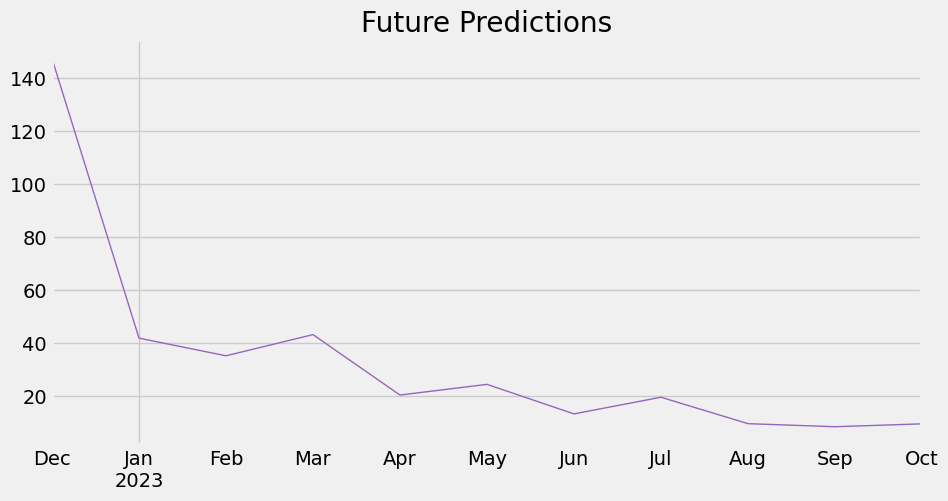

In [86]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [87]:
future_w_features['pred']

2022-12-01    147.343872
2023-01-01     41.976696
2023-02-01     35.328037
2023-03-01     43.306259
2023-04-01     20.532314
2023-05-01     24.561411
2023-06-01     13.432591
2023-07-01     19.707895
2023-08-01      9.745925
2023-09-01      8.591569
2023-10-01      9.674531
Name: pred, dtype: float32

In [88]:
pastDf = df.loc[df.index > '01-01-2015']

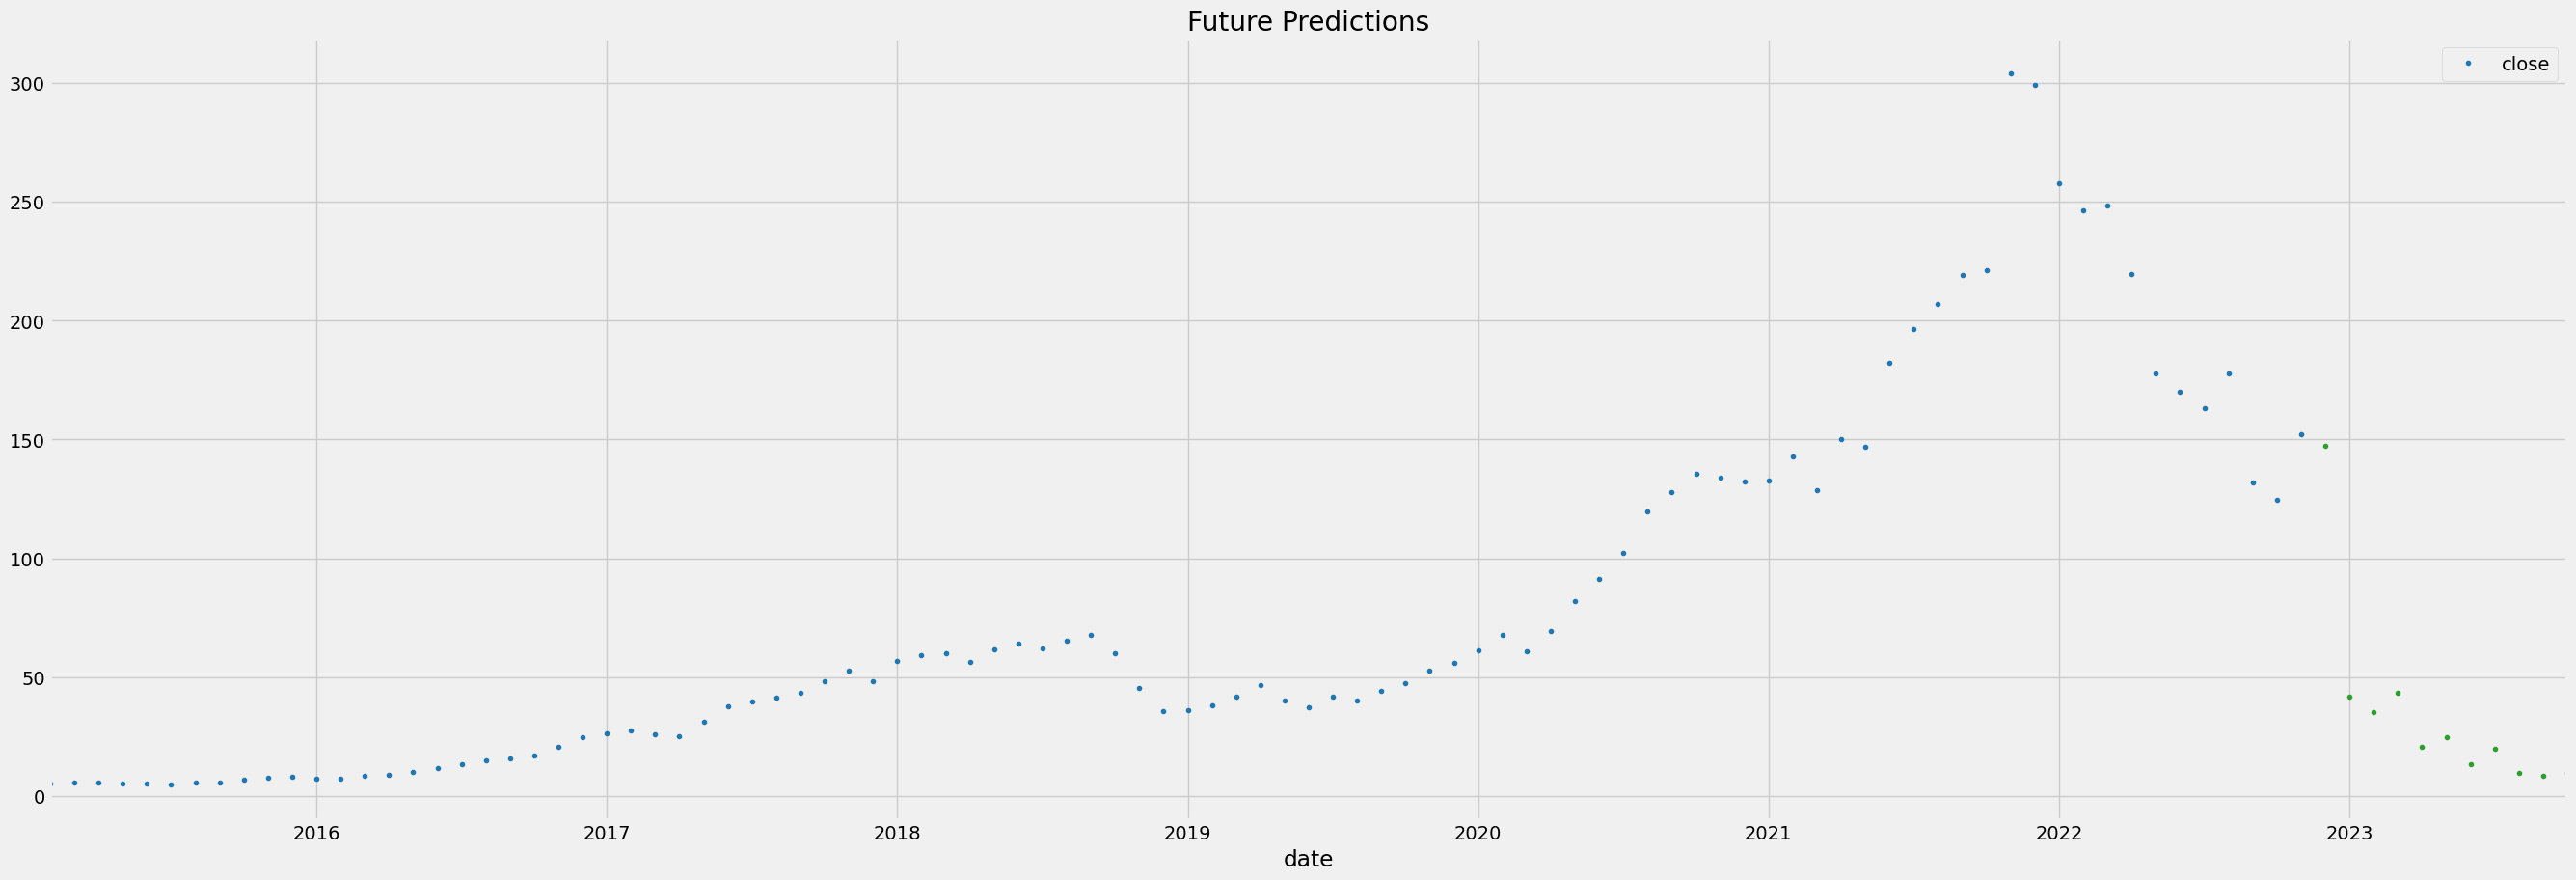

In [89]:
pastDf[['close']].plot(style='.',
        figsize=(30, 10),
        color=color_pal[0])
future_w_features['pred'].plot(style='.', figsize=(30, 10),
                               color=color_pal[2],
                               title='Future Predictions')
plt.show()

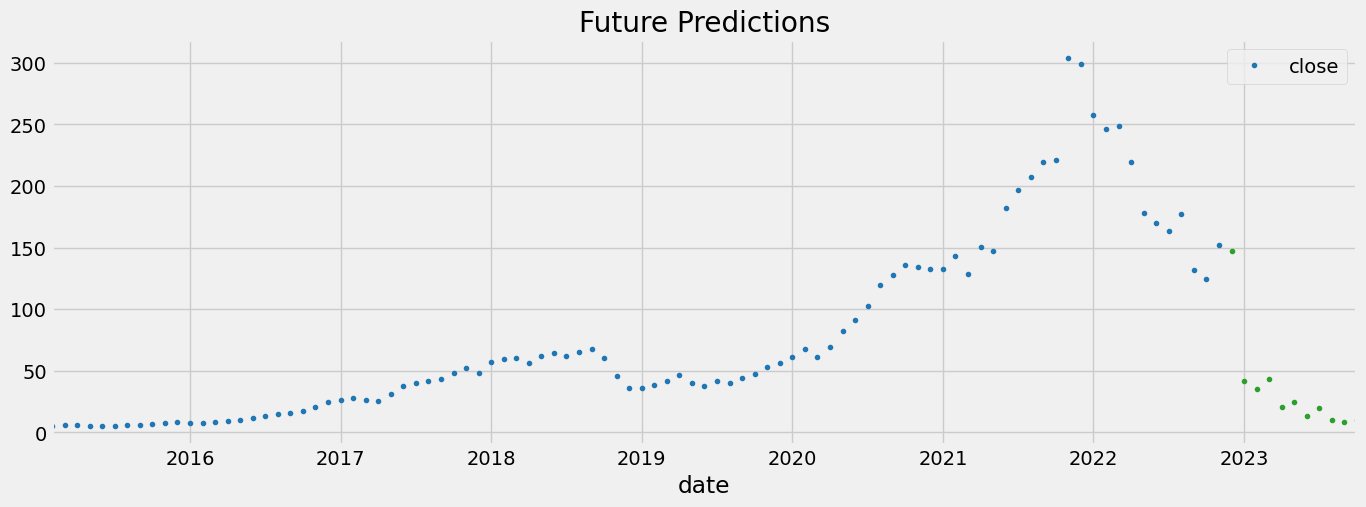

In [90]:
pastDf[['close']].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0])
future_w_features['pred'].plot(style='.', figsize=(15, 5),
                               color=color_pal[2],
                               title='Future Predictions')
plt.show()

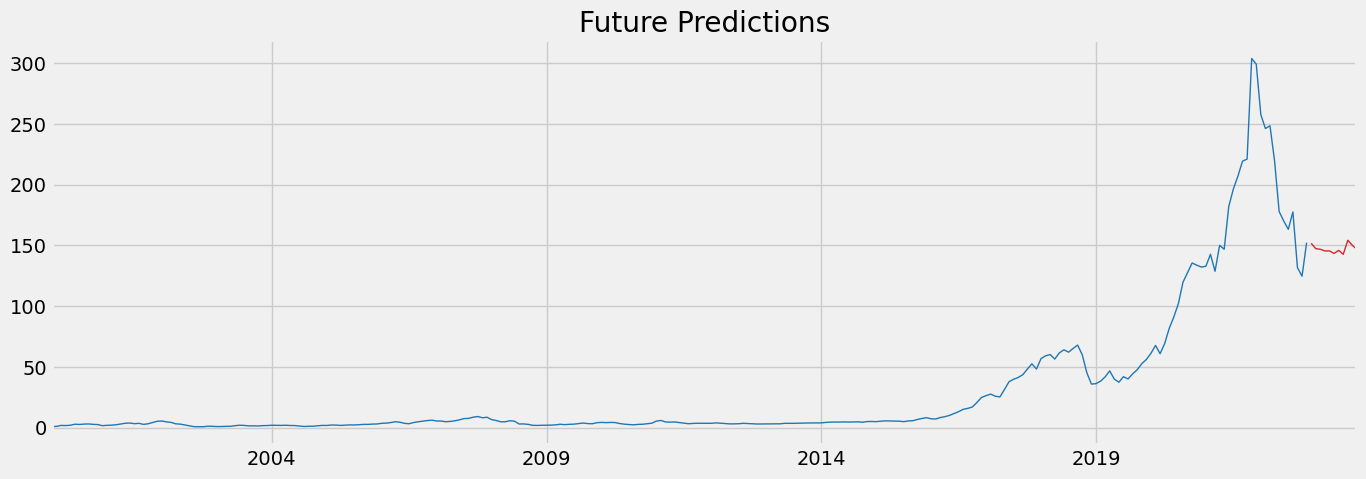